In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [12]:
df = DataFrame(XLSX.readtable("../../data/Macro_data_poland.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.year, first)

start = Date(2001, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data_source, start),end_d)

24×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-01-01 to 2024-01-01
┌────────────┬───────────────┬─────────────────┬─────────────────┬──────────────
│            │ NGDPRSAXDCPLQ │ IRLTLT01PLQ156N │ IR3TIB01PLQ156N │ NGDPDSAIXPL ⋯
├────────────┼───────────────┼─────────────────┼─────────────────┼──────────────
│ 2001-01-01 │     2.51454e5 │         10.4267 │         18.1733 │       76.89 ⋯
│ 2002-01-01 │     2.53341e5 │         8.30667 │            10.4 │      80.017 ⋯
│ 2003-01-01 │     2.59851e5 │         5.61333 │            6.24 │      79.629 ⋯
│ 2004-01-01 │     2.76062e5 │         6.71333 │         5.48333 │      82.192 ⋯
│ 2005-01-01 │     2.82491e5 │            5.75 │         6.27667 │      85.980 ⋯
│ 2006-01-01 │     2.98705e5 │         4.84333 │         4.24333 │      86.440 ⋯
│ 2007-01-01 │     3.18967e5 │         5.18333 │         4.21667 │      89.673 ⋯
│ 2008-01-01 │     3.38592e5 │         5.87333 │         5.91333 │      93.461 ⋯
│     ⋮      │       ⋮       │    

In [13]:
display(returns_summarystats(s_data, 1)) 

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
NGDPRSAXDCPLQ,1.02744e5,5.66966e5,3.9548e5,4.80756e5,2.51454e5,0.2411,3.13902e5,0.8809,-1.1286,3.8492,3.84524e5
IRLTLT01PLQ156N,2.0368,10.4267,4.9479,5.9083,1.34,0.5152,3.6192,0.6413,0.6643,2.4292,5.2583
IR3TIB01PLQ156N,3.6618,18.1733,4.6721,5.8758,0.21,2.1854,1.7975,0.5113,5.8894,1.2759,4.1817
NGDPDSAIXPLQ,20.3997,155.55,104.649,110.701,76.895,0.8965,88.8654,0.7896,0.5424,5.1299,104.747


nothing

In [14]:
freq = 1

cpi = percentchange(data_source[:NGDPDSAIXPLQ], :log) .* 100
gdp = percentchange(data_source[:NGDPRSAXDCPLQ], :log) .* 100
sr = (data_source[:IR3TIB01PLQ156N]) .- cpi
term = (data_source[:IRLTLT01PLQ156N]) .- (data_source[:IR3TIB01PLQ156N])

data= merge(gdp, cpi, sr, term)

start = Date(2001, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

#= display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))
 =#


23×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-01-01 to 2024-01-01
┌────────────┬───────────────┬──────────────┬──────────────────────────────┬────
│            │ NGDPRSAXDCPLQ │ NGDPDSAIXPLQ │ IR3TIB01PLQ156N_NGDPDSAIXPLQ │ I ⋯
├────────────┼───────────────┼──────────────┼──────────────────────────────┼────
│ 2002-01-01 │      0.747433 │      3.98018 │                      6.41982 │   ⋯
│ 2003-01-01 │       2.53708 │    -0.486305 │                      6.72631 │   ⋯
│ 2004-01-01 │       6.05179 │      3.16823 │                      2.31511 │   ⋯
│ 2005-01-01 │       2.30221 │        4.506 │                      1.77066 │   ⋯
│ 2006-01-01 │       5.58105 │     0.533791 │                      3.70954 │   ⋯
│ 2007-01-01 │       6.56316 │      3.67166 │                     0.545008 │   ⋯
│ 2008-01-01 │        5.9708 │       4.1376 │                      1.77573 │   ⋯
│ 2009-01-01 │         1.862 │      4.63413 │                      -0.1208 │   ⋯
│     ⋮      │       ⋮       │    

In [15]:
s_data

23×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-01-01 to 2024-01-01
┌────────────┬───────────────┬──────────────┬──────────────────────────────┬────
│            │ NGDPRSAXDCPLQ │ NGDPDSAIXPLQ │ IR3TIB01PLQ156N_NGDPDSAIXPLQ │ I ⋯
├────────────┼───────────────┼──────────────┼──────────────────────────────┼────
│ 2002-01-01 │      0.747433 │      3.98018 │                      6.41982 │   ⋯
│ 2003-01-01 │       2.53708 │    -0.486305 │                      6.72631 │   ⋯
│ 2004-01-01 │       6.05179 │      3.16823 │                      2.31511 │   ⋯
│ 2005-01-01 │       2.30221 │        4.506 │                      1.77066 │   ⋯
│ 2006-01-01 │       5.58105 │     0.533791 │                      3.70954 │   ⋯
│ 2007-01-01 │       6.56316 │      3.67166 │                     0.545008 │   ⋯
│ 2008-01-01 │        5.9708 │       4.1376 │                      1.77573 │   ⋯
│ 2009-01-01 │         1.862 │      4.63413 │                      -0.1208 │   ⋯
│     ⋮      │       ⋮       │    

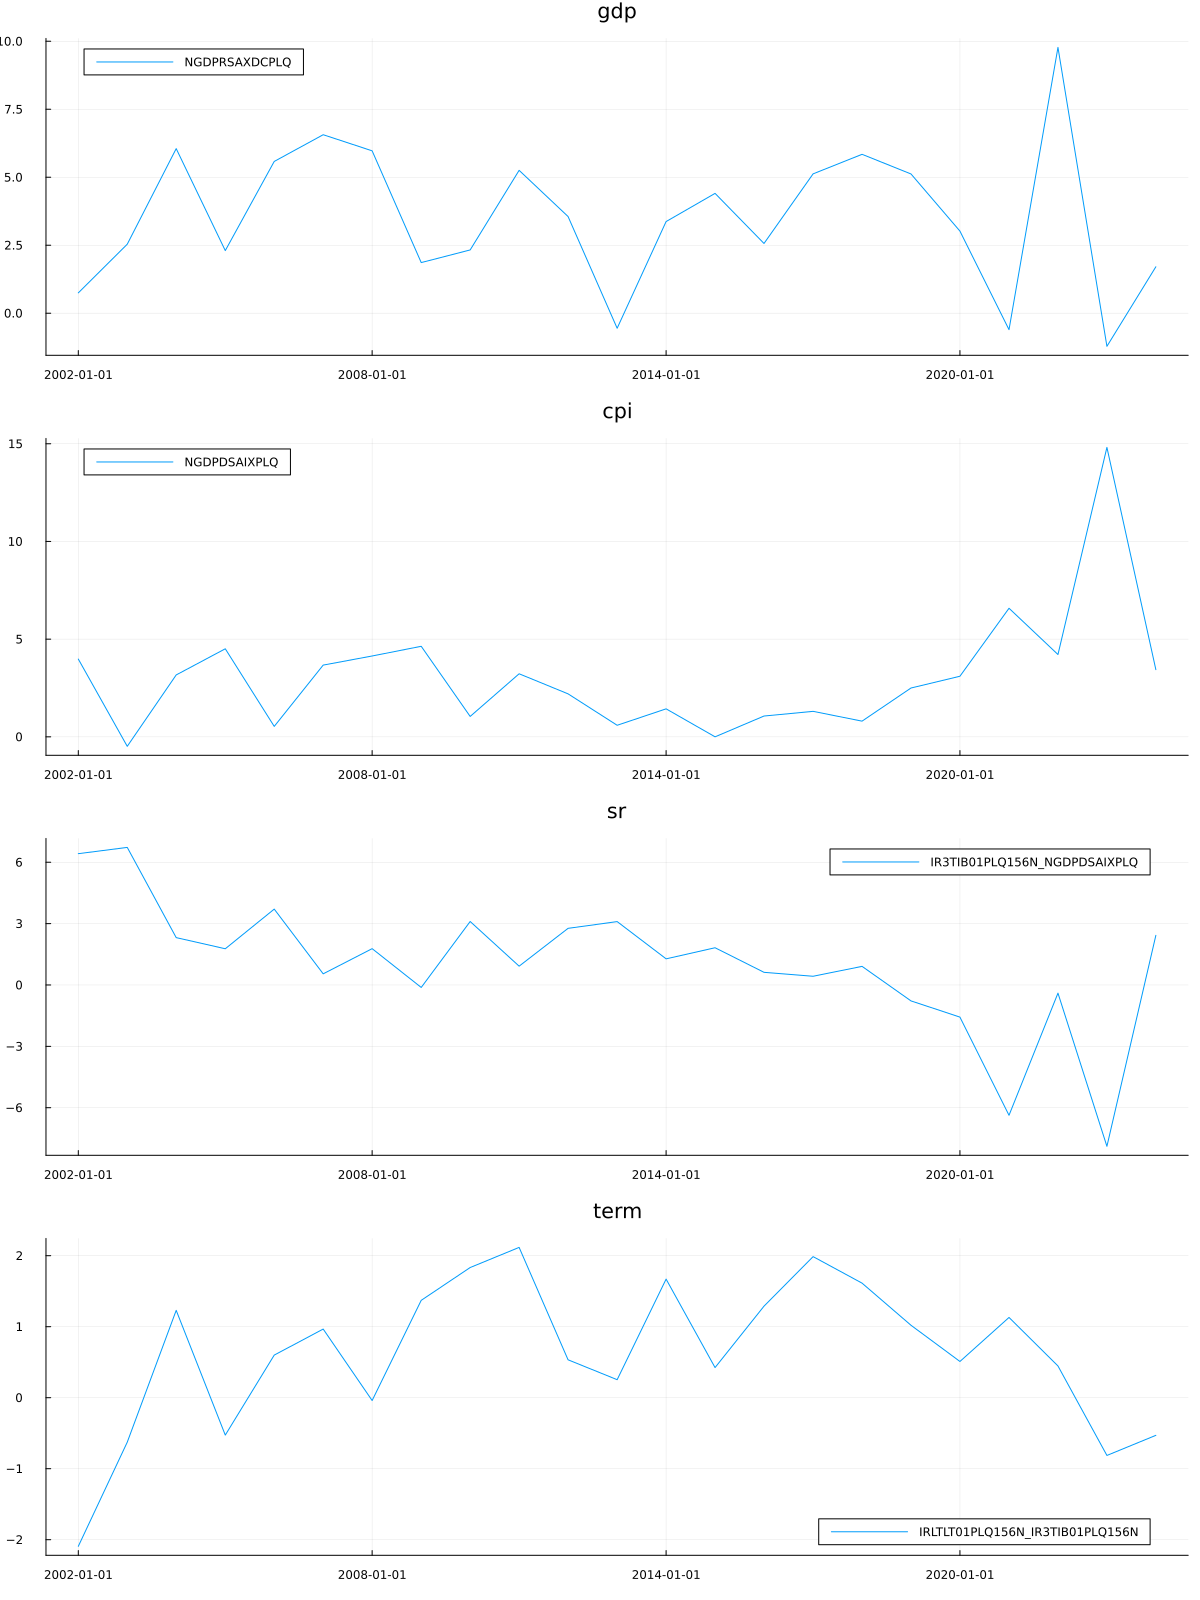

In [18]:
plot(s_data; layout = (4,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term"])

In [19]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N,std
NGDPRSAXDCPLQ,5.5461,-0.4182,-0.2509,-0.0718,0.682,2.5152
NGDPDSAIXPLQ,1.8107,0.8945,-0.1747,-0.618,-1.3313,2.3533
IR3TIB01PLQ156N_NGDPDSAIXPLQ,-2.2789,-0.6782,1.033,1.2781,1.6808,1.9374
IRLTLT01PLQ156N_IR3TIB01PLQ156N,1.8359,-0.1676,-0.1992,-0.0444,0.248,0.6366


,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N
NGDPRSAXDCPLQ,1.0,-0.17,0.46,-0.04
NGDPDSAIXPLQ,-0.17,1.0,-0.87,-0.0
IR3TIB01PLQ156N_NGDPDSAIXPLQ,0.46,-0.87,1.0,-0.17
IRLTLT01PLQ156N_IR3TIB01PLQ156N,-0.04,-0.0,-0.17,1.0


In [20]:
scenarios = simulate(model, 25*freq, 10_000)
#periods = [2,6, 16, 26]
periods = [1,5, 15, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,1.7073,3.4372,2.4262,-0.53
5,3.3266,2.6917,1.5042,0.5518
15,3.5481,3.1187,0.7083,0.6714
25,3.5926,3.2017,0.546,0.6947


,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,0.0,0.0,0.0,0.0
5,0.7347,1.1857,0.919,0.4217
15,0.4071,0.6585,0.8007,0.2858
25,0.3143,0.5095,0.6628,0.2272


,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,-1.0,NaN,-1.0,-1.0
5,0.0361,0.0198,0.0208,-0.0063
15,0.0487,-0.003,-0.0338,0.0055
25,-0.0153,-0.0282,-0.0226,-0.0103


,NGDPRSAXDCPLQ,NGDPDSAIXPLQ,IR3TIB01PLQ156N_NGDPDSAIXPLQ,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,-2.0,NaN,-2.0,-2.0
5,-0.0462,-0.0032,0.1036,-0.0367
15,0.0222,-0.0247,0.0653,0.0664
25,0.0224,0.0032,0.0427,-0.0393


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,1.7073,1.7073,1.7073,1.7073,1.7073,1.7073,1.7073,1.7073,1.7073
5,1.6389,1.8928,2.124,2.8256,3.3232,3.8136,4.5578,4.7752,5.0481
15,2.623,2.762,2.8819,3.2739,3.5474,3.8198,4.2282,4.3626,4.5142
25,2.8578,2.9744,3.0813,3.3789,3.5948,3.8087,4.1066,4.209,4.3226


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,3.4372,3.4372,3.4372,3.4372,3.4372,3.4372,3.4372,3.4372,3.4372
5,-0.0875,0.3548,0.7319,1.8976,2.6842,3.4767,4.6735,5.0476,5.4944
15,1.5666,1.8185,2.0399,2.6739,3.118,3.5631,4.2159,4.4126,4.6323
25,2.0036,2.1926,2.3673,2.859,3.2035,3.5453,4.0287,4.2061,4.369


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,2.4262,2.4262,2.4262,2.4262,2.4262,2.4262,2.4262,2.4262,2.4262
5,-0.616,-0.2893,0.0052,0.8934,1.4916,2.1253,3.0429,3.3171,3.6505
15,-1.1385,-0.8541,-0.5933,0.1705,0.707,1.2597,2.0151,2.2826,2.5503
25,-0.9796,-0.7553,-0.5539,0.1001,0.5494,0.9987,1.6329,1.8122,2.0905


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.53,-0.53,-0.53,-0.53,-0.53,-0.53,-0.53,-0.53,-0.53
5,-0.4364,-0.2809,-0.1419,0.2656,0.5511,0.8373,1.2484,1.3826,1.5191
15,0.0031,0.1177,0.2073,0.4809,0.6724,0.8622,1.1461,1.234,1.3319
25,0.1675,0.2452,0.3172,0.5416,0.6942,0.8501,1.0688,1.136,1.2204


In [21]:
sr = scenarios[2, :,:] + scenarios[3, :,:] 
lr = scenarios[2, :,:] + scenarios[3, :,:] + scenarios[4, :,:] 
#= real_Δd = scenarios[2, :,:] + scenarios[5, :,:]
dy = exp.(scenarios[6, :,:]) =#



print_scenarios_percentiles(sr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "sr")
print_scenarios_percentiles(lr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "lr")
#= print_scenarios_percentiles(cumsum(real_Δd, dims=1)[periods,:] ./ (periods.-1), [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "Δd")
print_scenarios_percentiles(dy[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "dy") =#



,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633
5,-0.8927,-0.1707,0.4322,2.2978,3.5791,4.8739,6.7937,7.3983,8.0836
15,-0.9126,-0.2091,0.4386,2.312,3.6281,4.9447,6.8031,7.4466,8.091
25,-0.878,-0.1301,0.4639,2.2954,3.6149,4.9573,6.8645,7.5043,8.3305


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333
5,0.8389,1.3893,1.8628,3.3764,4.4298,5.4446,6.9466,7.3804,8.0194
15,0.6986,1.3082,1.7855,3.301,4.3583,5.4018,6.9488,7.4127,7.934
25,0.6965,1.2867,1.7793,3.277,4.3575,5.4381,6.9745,7.5149,8.1454


In [590]:
real_Δd[1,:] .= 1.

div_index =values(data_source[:Dividend][end])[1] .* exp.(cumsum(real_Δd, dims=1) ./100)
price_index = div_index ./ dy
periods = [1, 5, 10, 25] * freq

eq_ret = log.((price_index[2:end,:] .+ div_index[2:end,:] ) ./ price_index[1:end-1,:])
eq_cum_ret = cumsum(eq_ret, dims=1)[periods,:] ./ periods
real_eq_ret = eq_ret .- (scenarios[2, 2:end, :] ./100)
real_eq_cum_ret = cumsum(real_eq_ret, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")
print_scenarios_percentiles(real_eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity real return")

,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.4352,-0.3651,-0.3064,-0.1312,-0.0053,0.1167,0.2918,0.3571,0.423
5,-0.111,-0.0902,-0.0714,-0.0169,0.0224,0.0612,0.1187,0.1365,0.1566
10,-0.0411,-0.0261,-0.0133,0.025,0.0517,0.0776,0.1156,0.1273,0.1436
25,0.0182,0.0269,0.0336,0.0552,0.0702,0.085,0.1062,0.1124,0.1203


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.4565,-0.3866,-0.3268,-0.153,-0.0301,0.0905,0.2646,0.3288,0.395
5,-0.1319,-0.1115,-0.0946,-0.0415,-0.0034,0.0344,0.0906,0.1065,0.1263
10,-0.0621,-0.0468,-0.0354,0.0022,0.0278,0.0531,0.0898,0.1026,0.1174
25,-0.0037,0.0043,0.0109,0.0321,0.0466,0.0612,0.082,0.0883,0.0957


In [606]:
mdd, mddl = max_drawdown_and_length(real_eq_ret)

display("real equity")
display("mdd")
display(quantile(mdd, [.05, .25, .5, .75, .95])')
display("mddl")
display(quantile(mddl, [.05, .25, .5, .75, .95])')

"real equity"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.246109  0.325045  0.385639  0.45553  0.561562

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 4.0  6.0  8.0  10.0  15.0

In [603]:
eq_return = calculate_equity_returns(real_Δd, scenarios[6, :,:])
eq_cum_return = cumsum(eq_return, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_return, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(25) and b has axes Base.OneTo(10)

In [593]:
percentile(eq_return[1,:], [.25, .5, .75])

3-element Vector{Float64}:
 -0.5247568309310805
 -0.485946901444126
 -0.4582612863750685

In [607]:
bond_returns = calculate_bond_returns(lr./100, 10, 1)
bond_cum_returns = cumsum(bond_returns, dims=1)[periods,:] ./ periods

real_bond_returns = bond_returns .- (scenarios[2, 2:end, :] ./100)
real_bond_cum_returns = cumsum(real_bond_returns, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "bonds returns")
print_scenarios_percentiles(real_bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "real bonds returns")


mdd, mddl = max_drawdown_and_length(real_bond_returns)

display("real bonds")
display("mdd")
display(quantile(mdd, [.05, .25, .5, .75, .95])')
display("mddl")
display(quantile(mddl, [.05, .25, .5, .75, .95])')


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.0234,-0.0061,0.0069,0.0527,0.0856,0.1202,0.1748,0.1924,0.2136
5,0.0148,0.0191,0.0237,0.0379,0.0482,0.059,0.0761,0.0819,0.088
10,0.0211,0.0245,0.0272,0.0365,0.0433,0.0501,0.0607,0.0642,0.0678
25,0.0252,0.0268,0.0283,0.0328,0.0361,0.0395,0.0445,0.0461,0.048


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.0551,-0.0368,-0.0221,0.0263,0.0613,0.0973,0.1541,0.1739,0.1968
5,-0.0195,-0.0139,-0.0083,0.0094,0.0225,0.0358,0.0562,0.0633,0.071
10,-0.0114,-0.0063,-0.0027,0.0102,0.0195,0.0288,0.0427,0.0472,0.0529
25,-0.0033,-0.0011,0.001,0.0077,0.0125,0.0175,0.0246,0.0268,0.0295


"real bonds"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.146678  0.212124  0.265808  0.322858  0.410193

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 6.0  9.0  11.0  15.0  20.0

In [595]:
B = collect(model.C[2:end,:]')

resp = girf(B, model.Σ, 10, 6, 1)



11×6 Matrix{Float64}:
 -1.40956     -0.194968     -0.193408    0.115515    -0.739853    0.168077
 -0.261       -0.451012     -0.127503    0.455694    -5.31063     0.0442706
  0.168095    -0.0001236    -0.458614    0.40375     -1.87766    -0.0169999
  0.225106     0.19403      -0.27731     0.0920347    0.480013   -0.00959322
  0.0661183    0.0937265     0.142173   -0.166806     1.00368     0.00505066
 -0.0924234   -0.0676378     0.290379   -0.156554     0.379553    0.00782083
 -0.107652    -0.115215      0.118848    0.0114164   -0.305082    0.00318087
 -0.0206941   -0.0520194    -0.0889203   0.115623    -0.393254   -0.000514745
  0.0477522    0.0190676    -0.125937    0.080442    -0.0441209  -0.000152856
  0.0421891    0.0310075    -0.0291936  -0.00811428   0.234401    0.00195097
 -0.00104091   0.000255492   0.0535112  -0.0478982    0.202153    0.00265958

In [596]:
resp[2,2] + resp[2,3]  + resp[2,4]

-0.12282084045033348

gdp + 
- sr .42
- lr .25

gdp -
- sr - .42
- lr - .25

cpi +
- sr .09
- lr .2


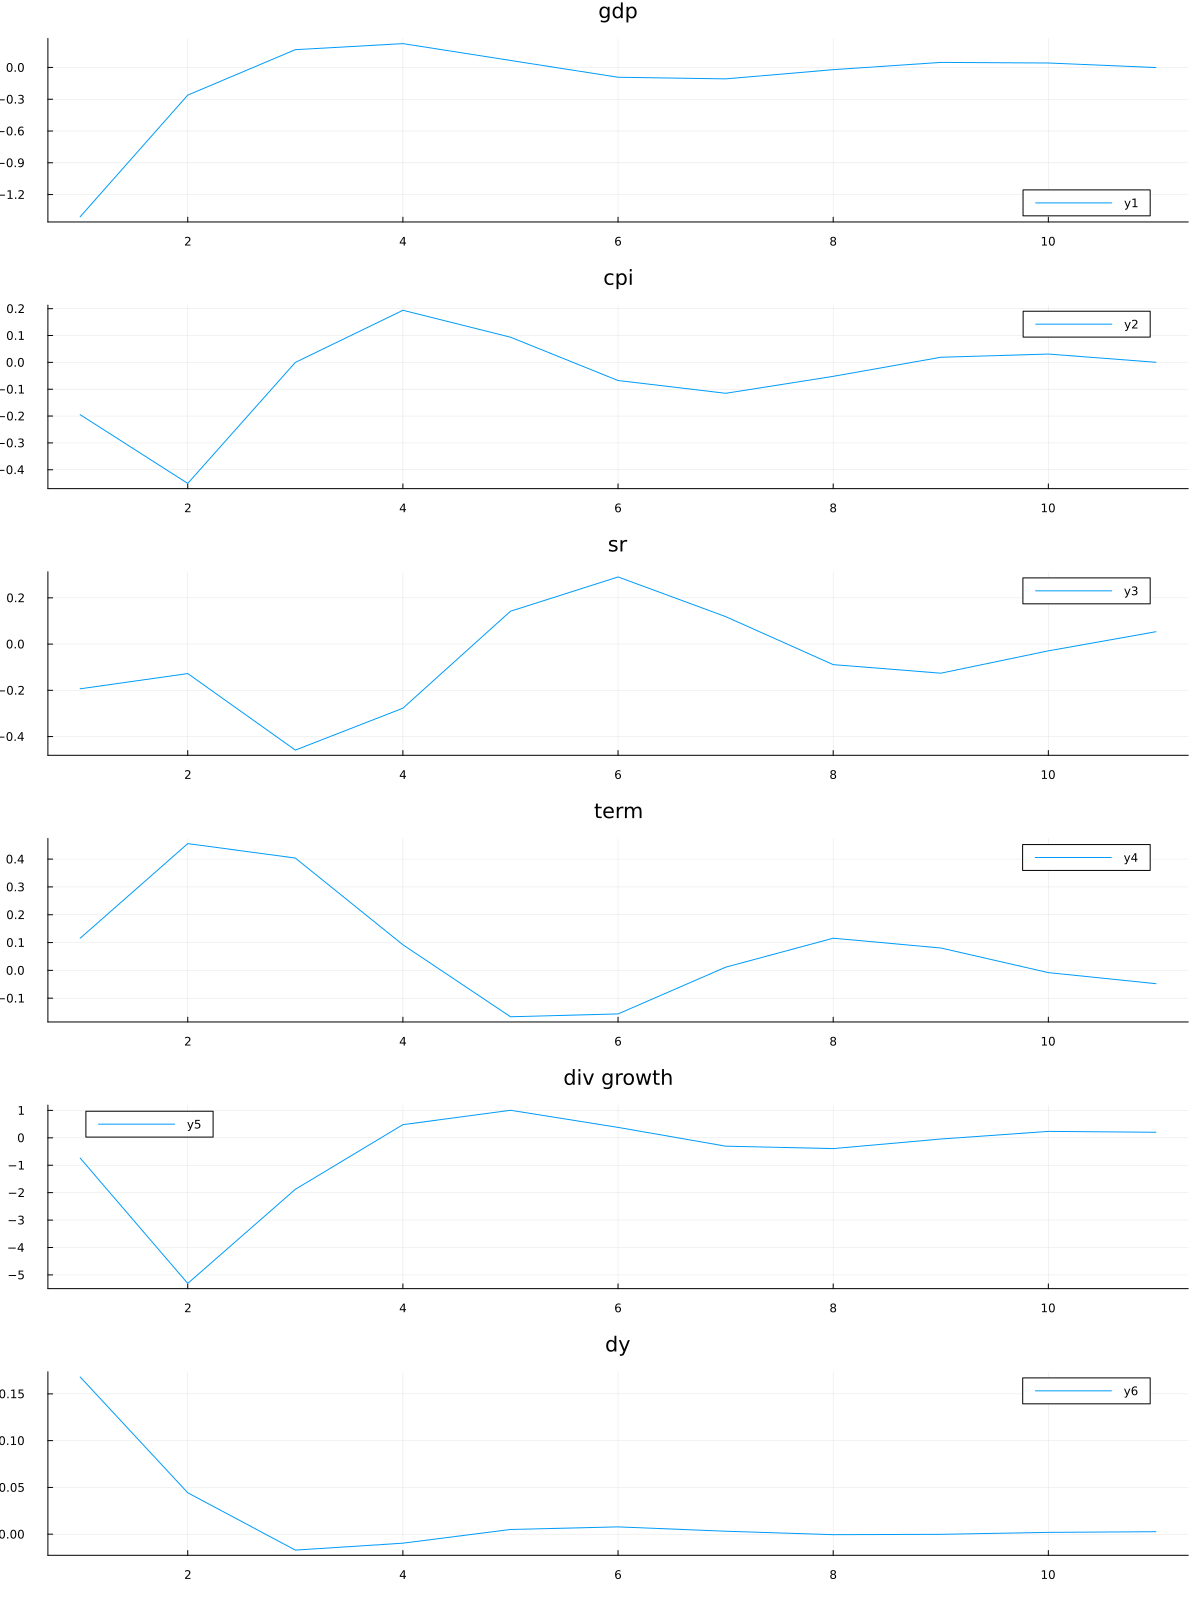

In [597]:
plot(resp; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [598]:
display(exp(-3.8 ) *100) 
display(exp(-3.8 + 0.08)*100) 
display((exp(-3.8 ) - exp(-3.8 + 0.08))*100) 
display(0.0224*exp((0.06^2)-1)^.5 *100)
display(exp(-4.8 ) *100) 

2.23707718561656

2.4233967845691122

-0.1863195989525522

1.3610764116758998

0.822974704902003

IRF returns
- estimate dy, and div idnex, based on initial value, mean?
- estimate returns?
- 

In [599]:
resp

11×6 Matrix{Float64}:
 -1.40956     -0.194968     -0.193408    0.115515    -0.739853    0.168077
 -0.261       -0.451012     -0.127503    0.455694    -5.31063     0.0442706
  0.168095    -0.0001236    -0.458614    0.40375     -1.87766    -0.0169999
  0.225106     0.19403      -0.27731     0.0920347    0.480013   -0.00959322
  0.0661183    0.0937265     0.142173   -0.166806     1.00368     0.00505066
 -0.0924234   -0.0676378     0.290379   -0.156554     0.379553    0.00782083
 -0.107652    -0.115215      0.118848    0.0114164   -0.305082    0.00318087
 -0.0206941   -0.0520194    -0.0889203   0.115623    -0.393254   -0.000514745
  0.0477522    0.0190676    -0.125937    0.080442    -0.0441209  -0.000152856
  0.0421891    0.0310075    -0.0291936  -0.00811428   0.234401    0.00195097
 -0.00104091   0.000255492   0.0535112  -0.0478982    0.202153    0.00265958

In [600]:
real_Δd = resp[:,2] + resp[:,5]




11-element Vector{Float64}:
 -0.934821304442061
 -5.761647018959759
 -1.8777812766049815
  0.6740423334651515
  1.0974016930866541
  0.31191532758721635
 -0.4202964890831895
 -0.4452736401967927
 -0.02505335009207915
  0.2654086557263483
  0.20240870076129597

In [601]:
dy = exp.(scenarios[6, :,:])

26×10000 Matrix{Float64}:
 0.0141223  0.0141223  0.0141223  …  0.0141223  0.0141223  0.0141223
 0.0164415  0.0147115  0.0161818     0.0158971  0.0226026  0.0133973
 0.0174507  0.0261337  0.0180935     0.0199947  0.0138882  0.0164948
 0.0140057  0.0266986  0.0186103     0.0233339  0.0181446  0.0237362
 0.0220876  0.0195852  0.0132214     0.0150901  0.0185109  0.018559
 0.0207153  0.016073   0.0161433  …  0.0179078  0.0186584  0.0125359
 0.0199477  0.0172669  0.0163747     0.0175082  0.01483    0.0117109
 0.0173304  0.015612   0.02287       0.0219893  0.0164443  0.0157709
 0.0195646  0.0174901  0.0176933     0.0143646  0.0259819  0.0157286
 0.0291443  0.0152727  0.0142933     0.0246171  0.019589   0.0151605
 ⋮                                ⋱                        
 0.0128458  0.0248805  0.0184985     0.0222547  0.0173169  0.011469
 0.0149798  0.0341468  0.015927      0.0180502  0.0148883  0.0151431
 0.0185377  0.0189786  0.0129209     0.0168193  0.0156737  0.0143867
 0.0220089  0.01534